# Logistic Regression: Baseline Model

This notebook establishes a simple, interpretable baseline using logistic regression.  
Key goals include:

- Assessing performance of feature-selected, preprocessed data
- Providing interpretable feature weights
- Establishing baseline metrics for comparison with non-linear models

Data source: `train_dataset_selected.csv`


## 1.Load Train Dataset

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load final selected dataset
df = pd.read_csv("../../data/processed/train_dataset_selected.csv")

# Split into features and labels
X = df.drop(columns=["label"])
y = df["label"]

# Stratified train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")

Train shape: (2280, 13), Test shape: (570, 13)


## 2. Train Logistic Regression

In [4]:
from sklearn.linear_model import LogisticRegression

# Create model
logreg = LogisticRegression(solver='liblinear', max_iter=5000, class_weight='balanced', random_state=42)

# Fit model
logreg.fit(X_train, y_train)

# Predict
y_pred = logreg.predict(X_test)
y_proba = logreg.predict_proba(X_test)[:, 1]


## 3. Evaluation Metrics

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.82      0.87       380
           1       0.71      0.89      0.79       190

    accuracy                           0.84       570
   macro avg       0.83      0.86      0.83       570
weighted avg       0.86      0.84      0.85       570



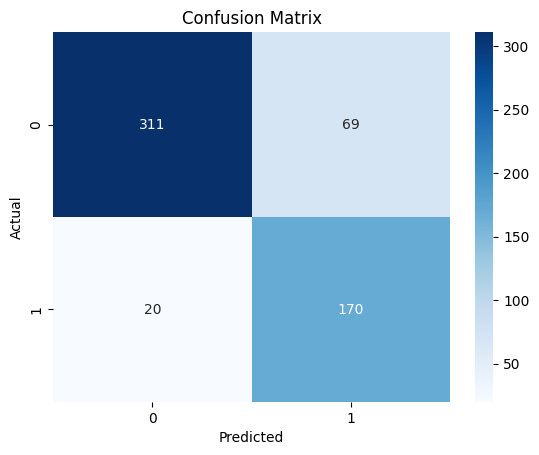

ROC AUC: 0.915


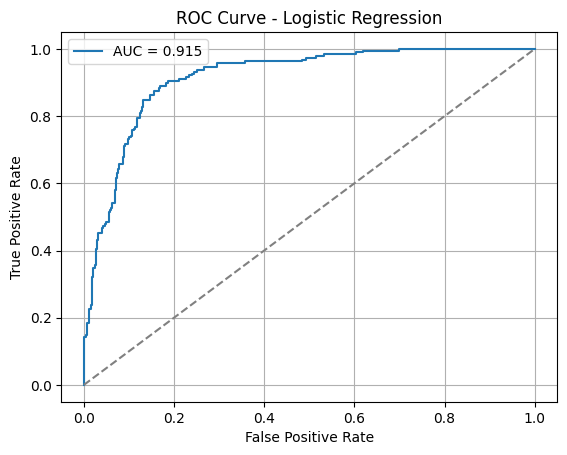

In [6]:
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score, roc_curve
)
import matplotlib.pyplot as plt
import seaborn as sns

# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ROC-AUC
auc = roc_auc_score(y_test, y_proba)
print(f"ROC AUC: {auc:.3f}")

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Logistic Regression")
plt.legend()
plt.grid(True)
plt.show()


## 4.Coefficient Interpretation

In [8]:
import numpy as np

# Coefficients summary
coef_df = pd.DataFrame({
    "Feature": X.columns,
    "Coefficient": logreg.coef_[0]
}).sort_values(by="Coefficient", key=np.abs, ascending=False)

print("Top coefficients by absolute magnitude:")
display(coef_df.head(10))


Top coefficients by absolute magnitude:


,Feature,Coefficient
12,mag_uc_12_16km_clipped,2.619375
7,radio_th_k_ratio_log,-2.246741
4,radio_u_ppm_log,0.602789
8,radio_u_k_ratio_log,-0.475153
11,mag_uc_4_8km_clipped,0.281763
10,mag_uc_2_4km_clipped,-0.262899
3,radio_th_ppm_log,-0.127664
9,mag_uc_1_2km_clipped,0.119363
6,radio_u_th_ratio_log,0.072809
5,radio_k_pct_log,0.026028


## 5. Logistic Regression Model Summary

This baseline model uses logistic regression to classify whether a location is likely to be associated with a porphyry copper deposit (`label=1`) or not (`label=0`), based on selected geophysical and geochemical features.

---

### 5.1. Performance Overview

| Metric          | Score  |
|-----------------|--------|
| Accuracy        | 0.84   |
| Precision (0)   | 0.94   |
| Recall (0)      | 0.82   |
| Precision (1)   | 0.71   |
| Recall (1)      | 0.89   |
| Macro F1-score  | 0.83   |
| ROC AUC         | **0.915** |

- The model achieves a strong ROC AUC of **0.915**, indicating excellent separability.
- **Recall for class 1 (porphyry)** is high at **0.89**, which is important for minimizing false negatives in exploration.
- Slight trade-off in **precision for class 1** (0.71), indicating some false positives—acceptable for exploratory tasks where recall is prioritized.

---

### 5.2. Confusion Matrix

|               | Predicted 0 | Predicted 1 |
|---------------|-------------|-------------|
| Actual 0      |     311     |     69      |
| Actual 1      |     20      |    170      |

- **False Positives (69)**: Non-porphyry regions incorrectly predicted as porphyry (can lead to over-investigation).
- **False Negatives (20)**: Porphyry samples missed (more critical in mineral exploration).

---

### 5.3. Most Influential Features

| Feature                  | Coefficient | Interpretation |
|--------------------------|-------------|----------------|
| `mag_uc_12_16km_clipped` | **+2.62**    | Strong positive signal at deep magnetic layer |
| `radio_th_k_ratio_log`   | **−2.25**    | High thorium/potassium ratio tends to reduce porphyry likelihood |
| `radio_u_ppm_log`        | +0.60       | Higher uranium concentrations associated with porphyry |
| `radio_u_k_ratio_log`    | −0.48       | Lower uranium/potassium ratio tends to be more predictive |
| `mag_uc_4_8km_clipped`   | +0.28       | Moderate magnetic signal at mid-depth |
| `mag_uc_2_4km_clipped`   | −0.26       | Slight inverse relationship at shallow depth |

> Features with large absolute coefficients have a stronger influence on the predicted outcome.
> Positive values indicate features that increase the probability of class 1 (porphyry).

---

### 5.4. Conclusion

- This logistic regression model provides a strong and interpretable baseline.
- High recall for porphyry samples demonstrates its **exploration utility**.
- Feature weights align with geophysical intuition (e.g., magnetic depth layers, uranium influence).
- Future work will benchmark this model against **non-linear models** (e.g., Random Forest, XGBoost) to seek further performance gains.


In [9]:
import joblib

joblib.dump(logreg, "../../models/logistic_regression_model.pkl")
print("Logistic Regression model saved to models/")


Logistic Regression model saved to models/
